In [1]:
import h5py
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
#from keras import backend as k
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D, Conv3D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import ReLU
from keras.layers import Reshape
from keras.layers import MaxPooling2D, MaxPooling3D
from keras.layers import Conv2DTranspose, Conv3DTranspose
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal


aalist = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]

Using TensorFlow backend.


In [103]:
df = pd.read_csv("./data/MHC-1_processed.csv")
alleles_list = list(pd.unique(df['allele']))
A_alleles = list(np.sort([idx for idx in alleles_list if idx.startswith("HLA-A")]))
B_alleles = list(np.sort([idx for idx in alleles_list if idx.startswith("HLA-B")]))
C_alleles = list(np.sort([idx for idx in alleles_list if idx.startswith("HLA-C")]))
all_alleles = [y for x in [A_alleles, B_alleles, C_alleles] for y in x]
targeted_alleles =[]
summary_df = pd.DataFrame(columns= ['Allele', '#Peptides'])
for mhc in all_alleles:
    sub_df = df[df['allele'] == mhc]
    if sub_df.shape[0] >= 200:
        targeted_alleles.append(mhc)
        summary_df = summary_df.append({'Allele': mhc, '#Peptides':sub_df.shape[0]}, ignore_index=True)
#print(summary_df)
summary_df

,Allele,#Peptides
0,HLA-A01:01,734
1,HLA-A02:01,4814
2,HLA-A02:02,1869
3,HLA-A02:03,2424
4,HLA-A02:06,2278
5,HLA-A02:11,404
6,HLA-A02:12,308
7,HLA-A02:19,234
8,HLA-A03:01,2180
9,HLA-A11:01,2226


In [105]:
np.max(summary_df)

Allele       HLA-B58:01
#Peptides          4814
dtype: object

In [3]:
def load__real_dataset(allele ="HLA-A01:01"):
    real_file = h5py.File("./data/MHCpan4.1/real_dataset_pure_encodeing.hdf5", "r")
    real_dataset = np.array(real_file[allele+"_dataset"])
    return real_dataset
# A function to generate a fake peptide
def generate_fake_peptide():
        x = np.zeros((20,9))
        rc = random.choices(range(20), k=9)
        for j in range(9):
            x[rc[j],j] =1
        return x
#  function to show a  real peptide sequence from row input data
def show_petide(x):
    x = pd.DataFrame(x[...,0], index = aalist)
    for i in range(x.shape[1]):
            v = list(x.loc[:,i]).index(np.max(list(x.loc[:,i])))
            vv = 20*[0]; vv[v] = 1
            x.loc[:,i] = vv
    #sns.heatmap(x, cbar=False, cmap="RdBu_r", linewidths=1)
    #plt.show()
    cdr = ""
    for i in range(9):
        v = [idx for idx, val in enumerate(list(x.loc[:, i])) if val > 0] 
        if len(v) > 0:
            cdr = cdr + "".join([aalist[vv] for vv in v])
    return cdr
# a function to  select n real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # expand to 3d, e.g. add channels dimension
    X = np.expand_dims(X, axis=-1)
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = np.zeros((n_samples,20, 9))
    for i in range(X.shape[0]):
        #laten_dim = np.random.randint(1,28)
        X[i] = generate_fake_peptide()
    
    X = np.expand_dims(X, axis=-1)
    # generate 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

In [4]:
###################################### THE DISRIMINATOR PART ##############################
# define the standalone discriminator model
def peptide_discriminator(in_shape=(20,9,1)):
    
    # weight initialization
    init = RandomNormal(stddev=0.02)
    model = Sequential()
    
    # convolution Block 1
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', kernel_initializer=init, input_shape=in_shape))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
   
    
    # convolution Block 2
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', kernel_initializer=init))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
   
    # classifier
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def train_peptide_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(n_samples= half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        if i%10==0:
            print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))


# define the standalone generator model for peptide sequences
def peptide_generator(latent_dim):
    
    # weight initialization
    init = RandomNormal(stddev=0.02)
    model = Sequential()
    # foundation for 5x3 image like array for the peptide
    n_nodes = 128*5*9
    # first layer
    model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5, 9,  128)))
    
   # second layer
    model.add(Conv2DTranspose(128, (2,2), strides=(2,1), padding='same', kernel_initializer=init))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
   # third- output layer
    model.add(Conv2DTranspose(128, (2,2), strides=(2,1), padding='same', kernel_initializer=init))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
   # output layer
    model.add(Conv2DTranspose(1, (1,1), strides=(1,1), padding='same', activation ='sigmoid', kernel_initializer=init))
    return model

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
# use the generator to generate n fake examples, with class labels
def generate_fake_peptide_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

def peptide_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

#***************************************************************************************************************************
###################################### THE COMPOSITE PART ##############################
#***************************************************************************************************************************
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10, n_batch=256):
    # manually enumerate epochs
    for i in range(n_epochs+1):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        
        
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, allele ="HLA-A02:01", n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake =generate_fake_peptide_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    #print('%d >Accuracy real: %.0f%%, fake: %.0f%%' % (epoch+1, acc_real*100, acc_fake*100))
    #if epoch %10 == 0 and epoch >0:
    # save the generator model tile file
    print('%d >Accuracy real: %.0f%%, fake: %.0f%%' % (epoch+1, acc_real*100, acc_fake*100))
    filename = './results/pure_encoding/'+allele+'generator_model_%05d.h5' % (epoch+1)
    g_model.save(filename)
        
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist, allele):
    # plot loss
    
    plt.subplot(2, 1, 1)
    plt.plot(d1_hist, label='d-real')
    plt.plot(d2_hist, label='d-fake')
    plt.plot(g_hist, label='gen')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    # plot discriminator accuracy
    plt.subplot(2, 1, 2)
    plt.plot(a1_hist, label='acc-real', color = 'blue')
    plt.plot(a2_hist, label='acc-fake', color = 'red')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.suptitle('Loss and accuracy for %s allele'%(allele))
    # save plot to file
    #plt.show()
    plt.savefig('results_baseline/plot_line_plot_loss_'+allele+'.png')
    plt.show()
    plt.close()        

In [26]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, allele, latent_dim, n_batch=128, n_epochs=100):
   # calculate the number of batches per epoch
    n_batch = n_batch if dataset.shape[0] >= n_batch else int(dataset.shape[0]/2)-1
    bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the total iterations based on batch and epoch
    n_steps = bat_per_epo * n_epochs
    # calculate the number of samples in half a batch
    print(n_batch, bat_per_epo, dataset.shape[0], n_steps)
    half_batch = int(n_batch/2)
    # prepare lists for storing stats each iteration
    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
    last_epoch =0
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_peptide_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            #print('>%d, d1=%.3f, d2=%.3f g=%.3f, a1=%d, a2=%d' % 
                  #(i+1, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2)))
        # record history
        d1_hist.append(d_loss1)
        d2_hist.append(d_loss2)
        g_hist.append(g_loss)
        a1_hist.append(d_acc1)
        a2_hist.append(d_acc2)
        # evaluate the model performance every 'epoch'
        if (i+1) % (10) == 0:
            print('>%d, d1=%.3f, d2=%.3f g=%.3f, a1=%d, a2=%d' % 
                  (i+1, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2)))
            filename = './results/pure_encoding/models/'+allele+'generator_model_%05d.h5' % (i+1)
            g_model.save(filename)
            last_epoch = i+1
            #print('file has been save', i+1)

    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist, allele)
    return last_epoch

In [6]:
# create the discriminator
#d = peptide_discriminator()
# create the generator
#g = peptide_generator(100)
    # create the gan
#gan = peptide_gan(g_model = g, d_model= d)
#g.summary()

In [119]:
#***************************************************************************************************************************
###################################### THE RUNNING PART ##############################
#***************************************************************************************************************************
def run_save(focused_allele ="HLA-A01:01", n_iters =1000, n_batch=128, latent_dim=100):
    
    # load the dataset
    ds = load__real_dataset(allele = focused_allele)
    #n_batch = n_batch if ds.shape[0] >= n_batch else int(ds.shape[0]/2)
    #print(n_batch)
    # calculate the number of batches per epoch
    #bat_per_epo = int(dataset.shape[0] / n_batch)
    # calculate the total iterations based on batch and epoch
    #n_steps = bat_per_epo * n_epochs
    
    # create the discriminator
    d = peptide_discriminator()
    # create the generator
    g = peptide_generator(latent_dim)
    # create the gan
    gan = peptide_gan(g_model = g, d_model= d)
    
    
    last_epoch = train(g_model=g, d_model=d, gan_model = gan, dataset=ds, latent_dim=latent_dim,\
          allele= focused_allele, n_batch=n_batch, n_epochs=n_iters)
    #print(last_epoch)
    
    pmodel = load_model('./results/pure_encoding/models/'+focused_allele+'generator_model_'+'%05d.h5'%(last_epoch))
    # generate peptides
    latent_points = generate_latent_points(latent_dim, 5000)
    df = pd.read_csv("./data/MHC-1_processed.csv")
    df = df[df['allele']==focused_allele]
    print(' The number of peptide for %s allele are  %d' %(focused_allele, df.shape[0]))

    X = pmodel.predict(latent_points)
    x = [show_petide(X[i]) for i in range(5000)]
    real_ba_peptides = list(df['peptide'])
    #sd = set.difference(set(x), set(real_ba_peptides))
    sd = [ i for i in x  if i not in real_ba_peptides]
    #xy =  set.intersection(set(x), set(real_ba_peptides))
    xy =  [ i for i in x  if i in real_ba_peptides]
    print("Number of unique novel peptide for "+ focused_allele+ ' are:%0f'% (len(sd)))
    #saving the generated peptides
    with open('./results/pure_encoding/Test/'+focused_allele+'.csv', 'w') as f:
        for i in sd:
            f.write(i+str("\n"))
    print(xy, 'done for this ', focused_allele)

128 6 776 1200
>10, d1=0.603, d2=0.790 g=0.610, a1=100, a2=0
>20, d1=0.352, d2=0.751 g=0.664, a1=100, a2=10
>30, d1=0.560, d2=0.755 g=0.651, a1=100, a2=7
>40, d1=0.590, d2=0.719 g=0.676, a1=100, a2=14
>50, d1=0.571, d2=0.683 g=0.711, a1=98, a2=64
>60, d1=0.715, d2=0.600 g=0.869, a1=45, a2=93
>70, d1=0.591, d2=0.671 g=0.737, a1=89, a2=57
>80, d1=0.370, d2=0.526 g=0.938, a1=100, a2=100
>90, d1=0.611, d2=0.735 g=0.707, a1=78, a2=23
>100, d1=0.814, d2=0.623 g=0.853, a1=9, a2=78
>110, d1=0.572, d2=0.506 g=0.951, a1=85, a2=100
>120, d1=0.504, d2=0.540 g=0.909, a1=100, a2=100
>130, d1=0.650, d2=0.747 g=0.683, a1=67, a2=6
>140, d1=0.756, d2=0.686 g=0.755, a1=29, a2=56
>150, d1=0.639, d2=0.668 g=0.760, a1=78, a2=79
>160, d1=0.629, d2=0.635 g=0.770, a1=70, a2=84
>170, d1=0.662, d2=0.625 g=0.785, a1=67, a2=98
>180, d1=0.645, d2=0.652 g=0.779, a1=73, a2=84
>190, d1=0.654, d2=0.666 g=0.753, a1=60, a2=71
>200, d1=0.653, d2=0.672 g=0.728, a1=60, a2=70


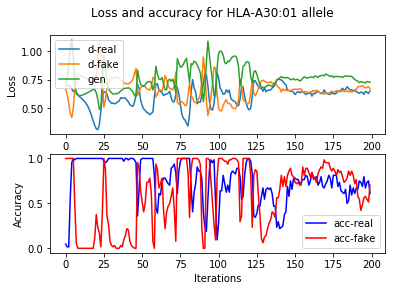

 The number of peptide for HLA-A30:01 allele are  776
Number of unique novel peptide for HLA-A30:01 are:5000.000000
[] done for this  HLA-A30:01


In [123]:
run_save(focused_allele = targeted_alleles[15], n_iters=200, n_batch=128, latent_dim=100)